In [136]:
# Imports
import os
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import classification_report, accuracy_score

### Test for the total embedding time

In [137]:
train = pd.read_csv('data/train.csv', delimiter=',')
train['reaction'][1]

'CC(=O)OC(\\C=C\\c1ccccc1)C#N>>CC(=O)OC(CC(=O)c1ccccc1)C#N'

In [151]:
train

,CLASS-ID,RX.ID,reaction,product_summary
0,272,20308219,CC1(C)O[C@H]2[C@H]3C[C@@H]([C@H]2O1)C(=O)C3>>C...,CC1(C)O[C@H]2[C@H]3C[C@H](NC(=O)C3)[C@H]2O1
1,84,20308266,CC(=O)OC(\C=C\c1ccccc1)C#N>>CC(=O)OC(CC(=O)c1c...,CC(=O)OC(CC(=O)c1ccccc1)C#N
2,68,20308388,CC1(C)O[C@H]2[C@H](OC(=O)[C@H]2O1)[C@@H](O)CO>...,C[C@H](O)[C@H]1OC(=O)[C@H]2OC(C)(C)O[C@@H]12
3,1872,20308549,O=Cc1ccccc1>>CC(C)NC(=S)c1ccccc1,CC(C)NC(=S)c1ccccc1
4,636,20308813,ClC(=O)c1ccccc1>>CCOC(=O)C(F)(F)[C@H](OC(=O)c1...,CCOC(=O)C(F)(F)[C@H](OC(=O)c1ccccc1)[C@H](O)CO
...,...,...,...,...
2405601,72,20308054,CCc1ccc2c3ccc4c(OC(C)=O)ccc([C@@H]5O[C@H](COC(...,CC(=O)OC[C@H]1O[C@H]([C@H](OC(C)=O)[C@@H]1OC(C...
2405602,42,20308093,CC1(C)C2CC1C(=C)CC2>>C[C@H]1CC[C@H]2C[C@@H]1C2...,C[C@H]1CC[C@H]2C[C@@H]1C2(C)C
2405603,42,20308094,CC1(C)C2CC1C(=C)CC2>>C[C@@H]1CC[C@H]2C[C@@H]1C...,C[C@@H]1CC[C@H]2C[C@@H]1C2(C)C
2405604,256,20308164,COC(=O)CCC[C@H](O)C=CBr>>COC(=O)CCC[C@H](O)C#C,COC(=O)CCC[C@H](O)C#C


In [ ]:
#pip install drfp

In [ ]:
from drfp import DrfpEncoder

In [ ]:
import time

sample = train.sample(1000)

start_time = time.time()
DrfpEncoder.encode(sample['reaction'], n_folded_length=128)
end_time = time.time()

average_time_per_sample = (end_time - start_time) / 1000

In [ ]:
total_items = len(train['reaction'])
estimated_total_time = total_items * average_time_per_sample

print(f"Total time for encoding: {estimated_total_time:.2f} seconds")

### Add parallel computing to less the time

In [ ]:
import os

print(f"Number of CPU cores: {os.cpu_count()}")

In [ ]:
from joblib import Parallel, delayed

def encode_reaction(reaction):
    return DrfpEncoder.encode(reaction, n_folded_length=128)

num_cores = 16

In [ ]:
sample = train.sample(1000)
# Time the processing of this sample
start_time = time.time()
sample_results = Parallel(n_jobs=num_cores)(delayed(encode_reaction)(i) for i in sample['reaction'])
sample_time = time.time() - start_time

# Estimate the time for the entire dataset
total_time_estimation = (sample_time / len(sample)) * len(train['reaction'])

print(f"Estimated time for full dataset: {total_time_estimation:.2f} seconds")

### Train data DRFP

In [ ]:
results = Parallel(n_jobs=num_cores)(delayed(encode_reaction)(i) for i in train['reaction'])

train['drfp'] = results

In [ ]:
X_train = np.array(train['drfp'].tolist()).astype('float32')
np.save('data/DRFP/X_train_DRFP.npy', X_train)

In [ ]:
train.to_csv('data/DRFP/train_DRFP.csv', index=False)

In [ ]:
#This is for dealing with some datatype/format issues
#import ast

#def convert_string_to_array(array_string):
   # array_string = array_string.replace("array(", "").replace(", dtype=uint8)", "")
   # return np.array(ast.literal_eval(array_string)).astype('float32')

# Assuming 'train' is your DataFrame
#train['drfp'] = train['drfp'].apply(convert_string_to_array)

### Test data DRFP

In [ ]:
test = pd.read_csv('data/test.csv', delimiter=',')
test

In [ ]:
results_test = Parallel(n_jobs=num_cores)(delayed(encode_reaction)(i) for i in test['reaction'])
test['drfp'] = results_test

In [ ]:
test.to_csv('data/DRFP/test_DRFP.csv', index=False)

In [ ]:
X_test = np.array(test['drfp'].tolist()).astype('float32')
np.save('data/DRFP/X_test_DRFP.npy', X_test)

### Val data DRFP

In [ ]:
val = pd.read_csv('data/val.csv', delimiter=',')

In [ ]:
results_val = Parallel(n_jobs=num_cores)(delayed(encode_reaction)(i) for i in val['reaction'])

val['drfp'] = results_val

In [ ]:
val.to_csv('data/DRFP/val_DRFP.csv', index=False)

In [ ]:
X_val = np.array(val['drfp'].tolist()).astype('float32')
np.save('data/DRFP/X_val_DRFP.npy', X_val)

### Data load

In [73]:
X_train = np.load('data/DRFP/X_train_DRFP.npy')
X_test = np.load('data/DRFP/X_test_DRFP.npy')
X_val = np.load('data/DRFP/X_val_DRFP.npy')

In [74]:
train = pd.read_csv('data/train.csv', delimiter=',')
test = pd.read_csv('data/test.csv', delimiter=',')
val = pd.read_csv('data/val.csv', delimiter=',')

In [75]:
y_train = train['CLASS-ID'].values
y_test = test['CLASS-ID'].values
y_val = val['CLASS-ID'].values

In [76]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)
X_val = np.squeeze(X_val)

### Test on val set (1NN)

In [78]:
import faiss
index = faiss.IndexFlatL2(X_train.shape[1])
index.add(X_train)

In [ ]:
k=1
D_val_1nn, I_val_1nn = index.search(X_val, k)  

In [ ]:
y_pred_val_1nn = np.array(y_train[I_val_1nn])

In [ ]:
np.save('data/DRFP/y_pred_val_1nn', y_pred_val_1nn)

In [ ]:
report_val1nn = classification_report(y_val, y_pred_val_1nn, output_dict=True)
report_df = pd.DataFrame(report_val1nn).transpose()
df_val1nn = report_df[:-3].reset_index().rename(columns={'index': 'CLASS-ID'})
df_val1nn['val_support'] = df_val1nn['support'].astype(int)
df_val1nn['CLASS-ID'] = df_val1nn['CLASS-ID'].astype(int)

#### Merge with train_support 

In [ ]:
train_class_support = train['CLASS-ID'].value_counts().sort_index()
train_support_df = train_class_support.reset_index()
train_support_df.columns = ['CLASS-ID', 'train_support']
train_support_df['CLASS-ID'] = train_support_df['CLASS-ID'].astype(int)

In [ ]:
# Merge with df_val1nn on 'CLASS-ID'
df_val1nn_report = pd.merge(df_val1nn, train_support_df, on='CLASS-ID', how='left')
# Sort based on the number of train_support
df_val1nn_report = df_val1nn_report.sort_values(by='train_support', ascending=False)
df_val1nn_report = df_val1nn_report.drop(columns=['support'])

#### Merge with class name

In [154]:
df_class = pd.read_csv('data/className.tsv', sep='\t', encoding='ISO-8859-1')

In [ ]:
# Convert multi Class-ID into one
def clean_class_id(row):
    # Split the string by comma and convert to a list
    class_ids = str(row['CLASS-ID']).split(',')
    # Return the first element from the list, ensuring it's an integer
    return int(class_ids[0].strip())

# Apply the function to the 'CLASS-ID' column
df_class['CLASS-ID'] = df_class.apply(clean_class_id, axis=1)
df_class['CLASS-ID'] = df_class['CLASS-ID'].astype(int)

In [ ]:
df_val1nn = pd.merge(df_val1nn_report, df_class[['CLASS-ID', 'TRANSFORM_NAME']], on='CLASS-ID', how='left')

In [ ]:
df_val1nn.to_csv('data/DRFP/df_val1nn.csv', index=False)

In [77]:
df_val1nn = pd.read_csv('data/DRFP/df_val1nn.csv', delimiter=',')
df_val1nn

,CLASS-ID,precision,recall,f1-score,val_support,train_support,TRANSFORM_NAME
0,1085,0.992473,0.991515,0.991994,24867,185024,"Suzuki coupling, Suzuki-Miyaura Cross-Coupling"
1,432,0.959968,0.968853,0.964390,21286,164914,N-alkylation of alkylamines
2,1016,0.927058,0.956641,0.941617,15637,113635,hydrolysis of carboxylic esters
3,60,0.974137,0.977800,0.975965,11171,85921,reduction of C-NO2 to C-NH2
4,433,0.969347,0.975844,0.972585,7907,60554,"N-alkylation of benzenoid amines, anilines"
...,...,...,...,...,...,...,...
1294,1267,1.000000,1.000000,1.000000,1,8,Brackeen Imidazole Synthesis
1295,1800,1.000000,0.200000,0.333333,5,8,Shestakov Hydrazino Acid Synthesis
1296,500,1.000000,0.500000,0.666667,2,7,"O-propargylation of N-hydroxy amides, includin..."
1297,1622,1.000000,1.000000,1.000000,3,7,ListMacMillan Hydrogenation


#### Evaluation on Val1nn

In [79]:
y_pred_val_1nn = np.load('data/DRFP/y_pred_val_1nn.npy')

In [80]:
print(f'Overall Accuracy: {accuracy_score(y_val, y_pred_val_1nn)}')

Overall Accuracy: 0.9263212563522666


In [100]:
# Calculate macro average for precision, recall, and f1-score
macro_precision = df_val1nn['precision'].mean()
macro_recall = df_val1nn['recall'].mean()
macro_f1 = df_val1nn['f1-score'].mean()

# Calculate weighted average for precision, recall, and f1-score
weighted_precision = (df_val1nn['precision'] * df_val1nn['val_support']).sum() / df_val1nn['val_support'].sum()
weighted_recall = (df_val1nn['recall'] * df_val1nn['val_support']).sum() / df_val1nn['val_support'].sum()
weighted_f1 = (df_val1nn['f1-score'] * df_val1nn['val_support']).sum() / df_val1nn['val_support'].sum()

### Test on val set (5NN)

In [ ]:
k=5
D_val_5nn, I_val_5nn = index.search(X_val, k) 

In [ ]:
y_pred_val_5nn = np.array([np.argmax(np.bincount(y_train[neighbors])) for neighbors in I_val_5nn])

In [ ]:
np.save('data/DRFP/y_pred_val_5nn', y_pred_val_5nn)

In [103]:
report_val5nn = classification_report(y_val, y_pred_val_5nn, output_dict=True)
report_df = pd.DataFrame(report_val5nn).transpose()
df_val5nn = report_df[:-3].reset_index().rename(columns={'index': 'CLASS-ID'})
df_val5nn['val_support'] = df_val5nn['support'].astype(int)
df_val5nn['CLASS-ID'] = df_val5nn['CLASS-ID'].astype(int)

/opt/conda/envs/reaction-workbench-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
# Merge with df_val1nn on 'CLASS-ID'
df_val5nn_report = pd.merge(df_val5nn, train_support_df, on='CLASS-ID', how='left')
# Sort based on the number of train_support
df_val5nn_report = df_val5nn_report.sort_values(by='train_support', ascending=False)
df_val5nn_report = df_val5nn_report.drop(columns=['support'])

In [105]:
df_val5nn = pd.merge(df_val5nn_report, df_class[['CLASS-ID', 'TRANSFORM_NAME']], on='CLASS-ID', how='left')

In [106]:
df_val5nn.to_csv('data/DRFP/df_val5nn.csv', index=False)

In [107]:
df_val5nn = pd.read_csv('data/DRFP/df_val5nn.csv', delimiter=',')
df_val5nn

,CLASS-ID,precision,recall,f1-score,val_support,train_support,TRANSFORM_NAME
0,1085,0.986178,0.987011,0.986594,24867,185024,"Suzuki coupling, Suzuki-Miyaura Cross-Coupling"
1,432,0.942204,0.958095,0.950083,21286,164914,N-alkylation of alkylamines
2,1016,0.887099,0.964763,0.924302,15637,113635,hydrolysis of carboxylic esters
3,60,0.947694,0.987736,0.967301,11171,85921,reduction of C-NO2 to C-NH2
4,433,0.953686,0.963577,0.958606,7907,60554,"N-alkylation of benzenoid amines, anilines"
...,...,...,...,...,...,...,...
1294,1267,1.000000,1.000000,1.000000,1,8,Brackeen Imidazole Synthesis
1295,1800,0.000000,0.000000,0.000000,5,8,Shestakov Hydrazino Acid Synthesis
1296,500,1.000000,0.500000,0.666667,2,7,"O-propargylation of N-hydroxy amides, includin..."
1297,1622,1.000000,1.000000,1.000000,3,7,ListMacMillan Hydrogenation


In [108]:
y_pred_val_5nn = np.load('data/DRFP/y_pred_val_5nn.npy')

In [110]:
# Calculate macro average for precision, recall, and f1-score
macro_precision1 = df_val5nn['precision'].mean()
macro_recall1 = df_val5nn['recall'].mean()
macro_f11 = df_val5nn['f1-score'].mean()

# Calculate weighted average for precision, recall, and f1-score
weighted_precision1 = (df_val5nn['precision'] * df_val5nn['val_support']).sum() / df_val5nn['val_support'].sum()
weighted_recall1 = (df_val5nn['recall'] * df_val5nn['val_support']).sum() / df_val5nn['val_support'].sum()
weighted_f11 = (df_val5nn['f1-score'] * df_val5nn['val_support']).sum() / df_val5nn['val_support'].sum()

In [127]:
output = f"""
Macro-averages
1nn                   5nn
- Precision: {macro_precision:.4f}   - Precision: {macro_precision1:.4f}
- Recall: {macro_recall:.4f}      - Recall: {macro_recall1:.4f}
- F1-score: {macro_f11:.4f}    - F1-score: {macro_f11:.4f}
----------------------------------------------------------------------------
Weighted-averages
1nn                   5nn
- Precision: {weighted_precision:.4f}   - Precision: {weighted_precision1:.4f}
- Recall: {weighted_recall:.4f}      - Recall: {weighted_recall1:.4f}
- F1-score: {weighted_f11:.4f}    - F1-score: {weighted_f11:.4f}
"""

### 1nn vs 5nn

In [125]:
print(f'Accuracy-1nn: {accuracy_score(y_val, y_pred_val_1nn)}')
print(f'Accuracy-5nn: {accuracy_score(y_val, y_pred_val_5nn)}')

Accuracy-1nn: 0.9263212563522666
Accuracy-5nn: 0.8941243609989703


In [128]:
print(output)


Macro-averages
1nn                   5nn
- Precision: 0.8823   - Precision: 0.8512
- Recall: 0.8467      - Recall: 0.7458
- F1-score: 0.7779    - F1-score: 0.7779
----------------------------------------------------------------------------
Weighted-averages
1nn                   5nn
- Precision: 0.9273   - Precision: 0.8969
- Recall: 0.9263      - Recall: 0.8941
- F1-score: 0.8923    - F1-score: 0.8923



### Test on test set

In [ ]:
k=1
D_test_1nn, I_test_1nn = index.search(X_test, k) 

In [ ]:
y_pred_test_1nn = np.array(y_train[I_test_1nn])

In [ ]:
np.save('data/DRFP/y_pred_test_1nn', y_pred_test_1nn)

In [ ]:
report_test1nn = classification_report(y_test, y_pred_test_1nn, output_dict=True)
report_df = pd.DataFrame(report_test1nn).transpose()
df_test1nn = report_df[:-3].reset_index().rename(columns={'index': 'CLASS-ID'})
df_test1nn['test_support'] = df_test1nn['support'].astype(int)
df_test1nn['CLASS-ID'] = df_test1nn['CLASS-ID'].astype(int)

In [ ]:
# Merge with df_val1nn on 'CLASS-ID'
df_test1nn_report = pd.merge(df_test1nn, train_support_df, on='CLASS-ID', how='left')
# Sort based on the number of train_support
df_test1nn_report = df_test1nn_report.sort_values(by='train_support', ascending=False)
df_test1nn_report = df_test1nn_report.drop(columns=['support'])

In [ ]:
df_test1nn = pd.merge(df_test1nn_report, df_class[['CLASS-ID', 'TRANSFORM_NAME']], on='CLASS-ID', how='left')

In [ ]:
df_test1nn.to_csv('data/DRFP/df_test1nn.csv', index=False)

In [86]:
df_test1nn = pd.read_csv('data/DRFP/df_test1nn.csv', delimiter=',')

In [87]:
df_test1nn

,CLASS-ID,precision,recall,f1-score,test_support,train_support,TRANSFORM_NAME
0,1085,0.992861,0.991508,0.992184,24966,185024,"Suzuki coupling, Suzuki-Miyaura Cross-Coupling"
1,432,0.960419,0.970177,0.965274,21259,164914,N-alkylation of alkylamines
2,1016,0.930275,0.953311,0.941652,15507,113635,hydrolysis of carboxylic esters
3,60,0.975512,0.975861,0.975686,11185,85921,reduction of C-NO2 to C-NH2
4,433,0.973701,0.979316,0.976500,7977,60554,"N-alkylation of benzenoid amines, anilines"
...,...,...,...,...,...,...,...
1294,1267,1.000000,1.000000,1.000000,1,8,Brackeen Imidazole Synthesis
1295,1800,1.000000,0.200000,0.333333,5,8,Shestakov Hydrazino Acid Synthesis
1296,500,1.000000,1.000000,1.000000,1,7,"O-propargylation of N-hydroxy amides, includin..."
1297,1622,1.000000,1.000000,1.000000,1,7,ListMacMillan Hydrogenation


In [84]:
y_pred_test1nn = np.load('data/DRFP/y_pred_test_1nn.npy')

In [129]:
# Calculate macro average for precision, recall, and f1-score
macro_precision2 = df_test1nn['precision'].mean()
macro_recall2 = df_test1nn['recall'].mean()
macro_f12 = df_test1nn['f1-score'].mean()

# Calculate weighted average for precision, recall, and f1-score
weighted_precision2 = (df_test1nn['precision'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()
weighted_recall2 = (df_test1nn['recall'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()
weighted_f12 = (df_test1nn['f1-score'] * df_test1nn['test_support']).sum() / df_test1nn['test_support'].sum()

In [133]:
output1 = f"""
Macro-averages:
- Precision: {macro_precision2:.4f}
- Recall: {macro_recall2:.4f}
- F1-score: {macro_f12:.4f}

Weighted-averages:
- Precision: {weighted_precision2:.4f}
- Recall: {weighted_recall2:.4f}
- F1-score: {weighted_f12:.4f}
"""

In [131]:
print(f'Accuracy: {accuracy_score(y_test, y_pred_test_1nn)}')

Accuracy: 0.926952026843203


In [134]:
print(output1)


Macro-averages:
- Precision: 0.8903
- Recall: 0.8603
- F1-score: 0.8675

Weighted-averages:
- Precision: 0.9279
- Recall: 0.9270
- F1-score: 0.9266



### Evaluation 

In [88]:
summary_stats = df_test1nn[["precision", "recall", "f1-score"]].describe()
summary_stats

,precision,recall,f1-score
count,1299.000000,1299.000000,1299.000000
mean,0.890264,0.860311,0.867475
std,0.182265,0.196462,0.182413
min,0.000000,0.000000,0.000000
25%,0.875000,0.807190,0.833333
50%,0.953586,0.928144,0.924370
75%,1.000000,1.000000,0.980642
max,1.000000,1.000000,1.000000


In [89]:
low_f1_reactions = df_test1nn[df_test1nn['f1-score'] < df_test1nn['f1-score'].quantile(0.25)]
low_f1_reactions

,CLASS-ID,precision,recall,f1-score,test_support,train_support,TRANSFORM_NAME
15,72,0.819018,0.813409,0.816204,3505,23643,oxidation of (CH2)2 to C=C
16,5,0.717607,0.740326,0.728790,3127,23357,reduction of aldehydes to alcohols
24,848,0.789173,0.842575,0.815000,2128,16370,condensation of heteroaryl carboxylic acids wi...
33,109,0.782669,0.691373,0.734194,1646,12611,"Dess-Martin ketone synthesis, Dess-Martin oxid..."
37,1331,0.564826,0.564487,0.564656,1667,12096,Corey-Suggs Reagent
...,...,...,...,...,...,...,...
1286,1890,0.500000,1.000000,0.666667,1,8,Zavyalov Pyrrole Synthesis
1287,1532,0.000000,0.000000,0.000000,1,8,"modified Julia olefination, using benzimidazol..."
1292,352,0.500000,1.000000,0.666667,1,8,nitrosation of benzenoid rings
1293,882,0.000000,0.000000,0.000000,1,8,condensation of nitroalkanes with amides


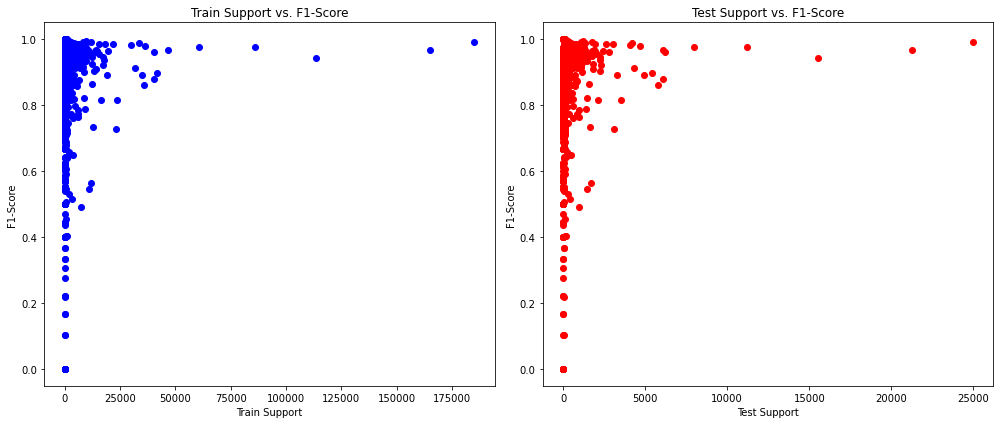

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.scatter(df_test1nn['train_support'], df_test1nn['f1-score'], color='blue')
ax1.set_title('Train Support vs. F1-Score')
ax1.set_xlabel('Train Support')
ax1.set_ylabel('F1-Score')

ax2.scatter(df_test1nn['test_support'], df_test1nn['f1-score'], color='red')
ax2.set_title('Test Support vs. F1-Score')
ax2.set_xlabel('Test Support')
ax2.set_ylabel('F1-Score')

plt.tight_layout()
plt.show()

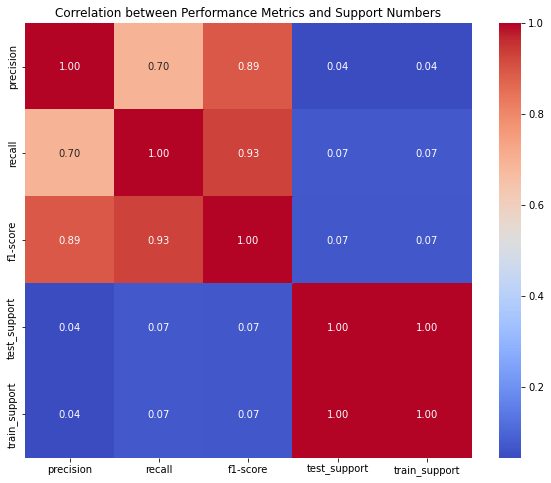

In [91]:
import seaborn as sns
correlation_matrix = df_test1nn[['precision', 'recall', 'f1-score', 'test_support', 'train_support']].corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
heatmap.set_title('Correlation between Performance Metrics and Support Numbers')
plt.show()

### Manual test(Will be improved)

In [174]:
Manually_input = 'CC(=O)OC(\\C=C\\c1ccccc1)C#N>>CC(=O)OC(CC(=O)c1ccccc1)C#N'

In [175]:
class_id_to_transform_name = pd.Series(df_class.TRANSFORM_NAME.values,index=df_class['CLASS-ID']).to_dict()

In [176]:
Input_FP = DrfpEncoder.encode(Manually_input, n_folded_length=128)
Input_FP_array = np.array(Input_FP).astype('float32')
Input_FP_array = Input_FP_array.reshape(1, -1)

k=1
D_man, I_man = index.search(Input_FP_array, k)

y_pred_manual_query = y_train[I_man]

In [177]:
y_pred_manual_query

array([[84]])